In [1]:
import torch
from torch_geometric.data import Data

import torch.nn as nn
import torch_geometric.nn as pyg_nn

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import numpy as np

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cuda


In [11]:
L = 1.0
num_nodes = 10
dx = L / (num_nodes - 1) # Distance between nodes

node_pos = torch.tensor([[i * dx] for i in range(num_nodes)], dtype=torch.float)

edge_index = []
for i in range(num_nodes - 1):
    edge_index.append([i, i + 1]) # Forward connection
    edge_index.append([i + 1, i]) # Backward connection (undirected graph)

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

x = node_pos.clone()

edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)

beam_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

print(beam_graph)

Data(x=[10, 1], edge_index=[2, 18], edge_attr=[18, 1])


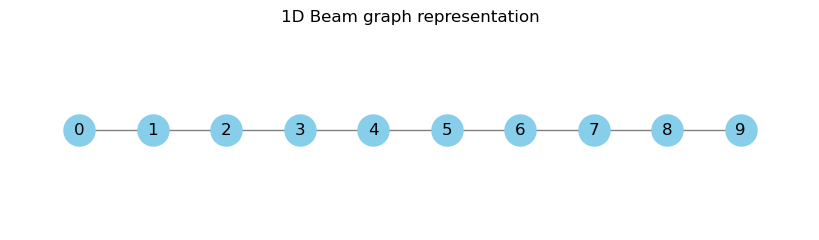

In [12]:
G = nx.Graph()
for i, pos in enumerate(node_pos.numpy()):
    G.add_node(i, pos=(pos[0], 0))

edge_list = edge_index.t().tolist()
G.add_edges_from(edge_list)

plt.figure(figsize=(8, 2))
pos = nx.get_node_attributes(G, 'pos')

nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=12)
plt.title("1D Beam graph representation")
plt.show()

In [23]:
bc = torch.zeros((num_nodes, 1))
forces = torch.zeros((num_nodes, 1))

bc[0] = 1
bc[-1] = 0

forces[num_nodes // 2] = -1.0

x = torch.cat((node_pos, bc, forces), dim=1)
beam_graph = Data(x=x, edge_index=edge_index)


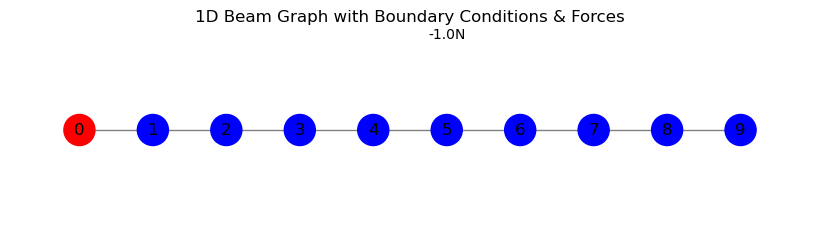

In [24]:
G = nx.Graph()
for i, pos in enumerate(node_pos.numpy()):
    G.add_node(i, pos=(pos[0], 0))  # Place nodes along x-axis

# Add edges
edge_list = edge_index.t().tolist()  # Convert tensor to list
G.add_edges_from(edge_list)

# Draw the graph with boundary conditions and forces
plt.figure(figsize=(8, 2))
pos = nx.get_node_attributes(G, 'pos')

# Node colors: fixed (red), free (blue)
node_colors = ["red" if bc[i] == 1 else "blue" for i in range(num_nodes)]

# Draw nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=12)

# Annotate forces
for i, force in enumerate(forces.numpy()):
    if force != 0:
        plt.text(pos[i][0], pos[i][1] + 0.05, f"{force[0]:.1f}N", fontsize=10, color="black", ha="center")

plt.title("1D Beam Graph with Boundary Conditions & Forces")
plt.show()

In [29]:
print(beam_graph.x)

tensor([[ 0.0000,  1.0000,  0.0000],
        [ 0.1111,  0.0000,  0.0000],
        [ 0.2222,  0.0000,  0.0000],
        [ 0.3333,  0.0000,  0.0000],
        [ 0.4444,  0.0000,  0.0000],
        [ 0.5556,  0.0000, -1.0000],
        [ 0.6667,  0.0000,  0.0000],
        [ 0.7778,  0.0000,  0.0000],
        [ 0.8889,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000]])


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Define the GNN model
class BeamGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BeamGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)  # Output: Predicted displacements
        return x

# Initialize the model
input_dim = 3  # [x-position, boundary condition flag, force]
hidden_dim = 16
output_dim = 1  # Predict displacement u

model = BeamGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [26]:
# Beam properties
E = 1  # Young’s modulus (Pa)
I = 1   # Moment of inertia (m^4)

def pinn_loss(model, data):
    u_pred = model(data)  # Predicted displacements

    # Compute second and fourth derivatives using finite differences
    dx = data.x[1, 0] - data.x[0, 0]  # Assume uniform spacing

    u_i = u_pred[2:-2]  # Interior nodes
    u_ip1 = u_pred[3:-1]
    u_im1 = u_pred[1:-3]
    u_ip2 = u_pred[4:]
    u_im2 = u_pred[:-4]

    # Fourth derivative approximation
    d4u_dx4 = (u_ip2 - 4*u_ip1 + 6*u_i - 4*u_im1 + u_im2) / (dx**4)

    # Physics-based loss: EI d^4u/dx^4 = f
    f_i = data.x[2:-2, 2]  # External forces on interior nodes
    physics_loss = F.mse_loss(E * I * d4u_dx4, f_i.view(-1, 1))

    # Boundary condition loss (Dirichlet conditions)
    bc_nodes = (data.x[:, 1] == 1).nonzero(as_tuple=True)[0]  # Nodes with fixed BC
    bc_loss = F.mse_loss(u_pred[bc_nodes], torch.zeros_like(u_pred[bc_nodes]))

    # Total loss
    return physics_loss + bc_loss


In [27]:
# Training loop
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, beam_graph)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 65470.67578125
Epoch 100, Loss: 0.39577409625053406
Epoch 200, Loss: 0.04540858417749405
Epoch 300, Loss: 0.014047185890376568
Epoch 400, Loss: 0.003736641025170684
Epoch 500, Loss: 0.0007935435278341174
Epoch 600, Loss: 0.00013195302744861692
Epoch 700, Loss: 1.752005482558161e-05
Epoch 800, Loss: 1.8766829725791467e-06
Epoch 900, Loss: 1.5699815492098423e-07
Epoch 1000, Loss: 1.753803502424489e-08
Epoch 1100, Loss: 1.371289082285898e-09
Epoch 1200, Loss: 1.9824565100634572e-08
Epoch 1300, Loss: 1.1301484192927091e-08
Epoch 1400, Loss: 2.9656851197046308e-08
Epoch 1500, Loss: 6.750109093900392e-08
Epoch 1600, Loss: 2.6913603790035268e-08
Epoch 1700, Loss: 6.707697508545607e-08
Epoch 1800, Loss: 3.0813598783652196e-08
Epoch 1900, Loss: 7.1968129233823674e-09


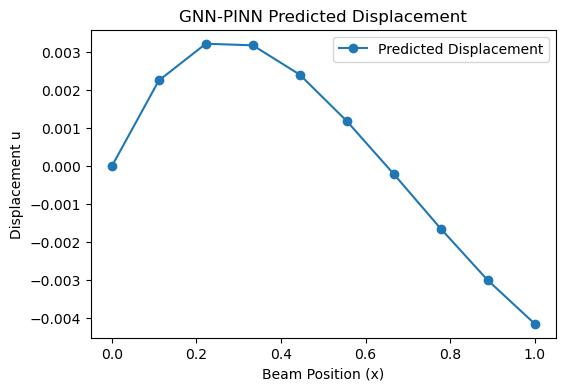

In [28]:
import matplotlib.pyplot as plt

# Get predictions
with torch.no_grad():
    u_pred = model(beam_graph).numpy()

# Plot displacement along the beam
plt.figure(figsize=(6, 4))
plt.plot(beam_graph.x[:, 0], u_pred, 'o-', label="Predicted Displacement")
plt.xlabel("Beam Position (x)")
plt.ylabel("Displacement u")
plt.title("GNN-PINN Predicted Displacement")
plt.legend()
plt.show()
